<hr style="height:2px;">

# Targeted multi-contrast microscopy using attention-based multi-instance learning for tissue sections

In this tutorial, we will perform a selective acquisition on a tissue micro-array (TMA) core containing pancreatic cancer with a brightfield camera (QCamera) and Second-harmonic generation (SHG) laser scanning microscopy. 

This acquisition workflow adaptively zooms in specific regions and performs multimodal imaging according to the contributions of these regions to the triggering of the classifier, which are explicitly expressed as attention scores in the attention-based machine learning model. This acquisition scheme can reduce the data volume and downstream data analysis computation complexity compared to an imaging scheme where the whole sample is imaged in the target magnifications. The decision of which regions to zoom in and perform SHG imaging is based on data-driven machine learning outputs.

This machine learning technique is called multi-instance learning. Details regarding attention-based multi-instance learning can be found at https://arxiv.org/pdf/1802.04712.pdf. The specific model used in this tutorial  is described at https://arxiv.org/pdf/2006.05538.pdf.

We will first snap a brightfield image at low resolution (4x) via Pycro-Manager. The pre-trained model weights will be loaded and the model will be running in inference mode. The model is implemented in PyTorch and it is pre-trained for pancreatic cancer detection.The machine learning model performs the inference on the 4x magnification image and the attention scores are obtained for each sub-region. The model then selects the top k highest-attention sub-regions and sends commands of stage moving, objective switching, and modality switching to Micro-Manager through Pycro-Manager. 
Micro-Manager then acquires z-stacks of these selected regions at 20x magnification with SHG imaging. 

SHG imaging is handled by a Micro-Manager C library for laser scanning, it appears as a camera device after installation. https://eliceirilab.org/openscan/.

## Hardware device list
- ASI Tiger controller
- ASI Dual objective slider
- ASI XY moter
- ASI Z motor
- QCamera
- OpenScan laser scanning devices https://eliceirilab.org/openscan/

## Python environment

### Required packages
Dependencies:
  - cudatoolkit=10.1 (optional)
  - numpy=1.18.1
  - opencv=3.4.2
  - pillow=7.0
  - pip=20.0
  - python=3.7.6
  - pytorch=1.4.0
  - torchvision=0.5.0
  - matplotlib=3.1.3
  - scikit-learn=0.23.1
  - pyyaml=5.3.1
  - pyimagej=0.5.0
  - pandas=1.0.5
  - scikit-image=0.16.2
  
### Setup Pycro-Manager
https://pycro-manager.readthedocs.io/en/latest/index.html


In [1]:
import argparse
import copy
import glob
import os
import random
import time
import warnings
from collections import OrderedDict
from os import listdir, makedirs, mkdir
from os.path import exists, isdir, isfile, join

import cv2
import imagej
import matplotlib.pyplot as plt
import mil_dsmil_softmax as mil
import numpy as np
import pandas as pd
import torch
import torch.functional as F
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms.functional as VF
from image_utils import *
from PIL import Image
from pytorch_utils import *
from skimage import (
    color,
    exposure,
    img_as_bool,
    img_as_float,
    img_as_ubyte,
    io,
    transform,
)
from skimage.filters import threshold_mean
from skimage.util import crop, pad
from skimage.util.shape import view_as_windows
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
from utils import *

from pycromanager import Acquisition, Bridge, multi_d_acquisition_events

In [2]:
warnings.simplefilter("ignore", UserWarning)

In [3]:
bridge = Bridge()
core = bridge.get_core()

### Utils for changing hardware properties

These functions will be used to switch between objectives and imaging modalities.

We can set the hardware state by directly writing the hardware properties via CMMCore. Syntax: core.set_property([string _property-name_, string _property-value_ ])

In [4]:
def switch_objective(target="20x"):
    if core.get_property("Turret:O:35", "Label") == "20x" and target == "4x":
        core.set_position(22835)
        time.sleep(3)
        core.set_property("Turret:O:35", "Label", target)
    if core.get_property("Turret:O:35", "Label") == "4x" and target == "20x":
        core.set_property("Turret:O:35", "Label", target)
        time.sleep(3)
        core.set_position(19370)
    print("Swtich to objective: " + core.get_property("Turret:O:35", "Label"))


### LED sanity check
def LED_check(exposure="30.00", voltage="1"):
    if core.get_property("Core", "Camera") == "QCamera":
        core.set_property("QCamera", "Exposure", exposure)  ### color mode ON
        core.set_property("LED-Dev1ao0", "Voltage", voltage)

Or, we can control the hardware state by changing the state of pre-defined Micro-Manager configuration groups. Syntax: core.set_config([string _group-name_, string _config-name_ ])

We set up a configuration group called "Imaging" with two states: QCamera and OSc-LSM. Switching between the two states can apply settings for shutters, PMT, and the camera. Details regarding how to use configuration groups to define sets of hardware properties can be found at https://micro-manager.org/wiki/Version_2.0_Users_Guide#Configuration_Groups.

In [4]:
### switch to bright-field
def switch_brightfield(exposure="30.00", hard_set=False):
    current_lens = core.get_property("Turret:O:35", "Label")
    if core.get_property("Core", "Shutter") == "UniblitzShutter" or hard_set:
        core.set_config("Imaging", "QCamera")
        if core.get_property("Core", "Camera") == "QCamera":
            print("Switched to bright-field, current obejective: " + current_lens)
    else:
        print("Already in Brightfield, current objective: " + current_lens)


### switch to bright-field
def switch_shg(average="1", hard_set=False):
    current_lens = core.get_property("Turret:O:35", "Label")
    if core.get_property("Core", "Shutter") == "WhiteLED" or hard_set:
        core.set_config("Imaging", "OSc-LSM")
        if core.get_property("Core", "Camera") == "OSc-LSM":
            print("Switched to SHG, current obejective: " + current_lens)
    else:
        print("Already in SHG, current objective: " + current_lens)

### Start at 4x, brightfield
Switch the objective to 4x and the modality to brightfield, set the lamp LED intensity.

In [5]:
switch_objective("4x")
switch_brightfield(hard_set=True)
LED_check(voltage="0.16")

Swtich to objective: 4x
Switched to bright-field, current obejective: 4x


Load some pre-collected brightfield background images, these will be used for white-balance and flat-field correction.

In [6]:
### load pre-collected background images and estimate the background by averaging
bg_img = np.flip(estimate_bg("bright_field_bgs\\"), 2)

Snap brightfield image at low resolution, perform white-balance and flat-field correction. We can easily snap a image via core.snap_image() and access the image data via core.get_tagged_image().pix

Brightfield 4x TMA core, raw


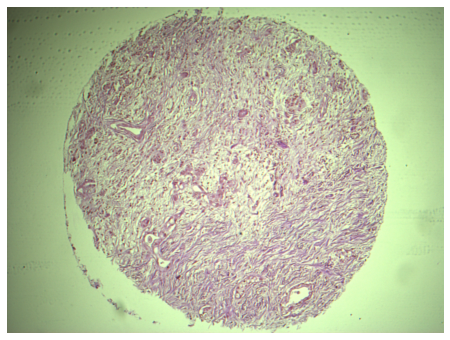

Brightfield 4x TMA core, corrected


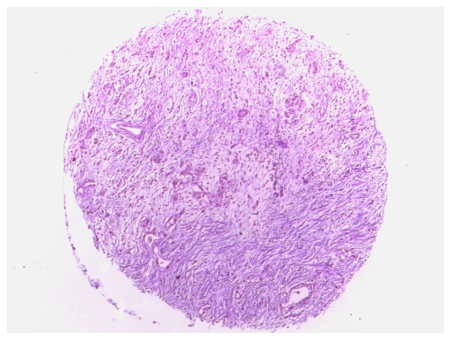

In [7]:
### capture brightfield image
core.snap_image()
tagged_image = core.get_tagged_image()
if core.get_property("QCamera", "Color") == "ON":
    pixels = np.reshape(
        tagged_image.pix,
        newshape=[tagged_image.tags["Height"], tagged_image.tags["Width"], 4],
    )
else:
    pixels = np.reshape(
        tagged_image.pix,
        newshape=[tagged_image.tags["Height"], tagged_image.tags["Width"]],
    )

img_data = copy.deepcopy(pixels)
bg_data = copy.deepcopy(bg_img)
wb_out = white_balance(img_data, bg_data)
bg_data = white_balance(bg_data, bg_data)
output = flat_field(wb_out, bg_data)
print("Brightfield 4x TMA core, raw")
plt.figure(figsize=(8, 6))
imgplot = plt.imshow(pixels)
plt.axis("off")
plt.show()
print("Brightfield 4x TMA core, corrected")
plt.figure(figsize=(8, 6))
imgplot = plt.imshow(img_as_ubyte(output))
plt.axis("off")
plt.show()

Bounding TMA core image, remove surronding background.

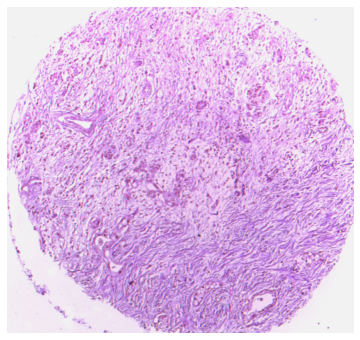

In [8]:
box = bounding_tma(output)
bounded_tma = output[box[1] : box[3], box[0] : box[2], :]
plt.figure(figsize=(8, 6))
imgplot = plt.imshow(img_as_ubyte(bounded_tma))
plt.axis("off")
plt.show()

### Load ImageJ/FIJI.
Please download FIJI https://imagej.net/Fiji and put it to the same directory as the notebook inside a folder called "Fiji".

In [9]:
print("loading ImageJ, please wait")
ij = imagej.init("Fiji/Fiji.app/")

loading ImageJ, please wait


### Create the attention-based neural network and load pre-trained weights. 

One key feature of histopathological data is that the images are seldom annotated with boundaries of malignant regions, but rather a single label of benign or malignant for the whole image. Since the images are too large for convolutional neural networks even in the low resolution, in order to train classifiers and to localize malignant regions, multi-instance learning approaches and attention-based mechanisms are often used. Details regarding the use of these approaches can be found at https://www.nature.com/articles/s41591-019-0508-1 and https://arxiv.org/pdf/1802.04712.pdf.

We will densely crop the 4x image (1k x 1k resolution) into 224 x 224 patches with no overlap, and feed all the patches into the model at once. The model returns attention scores for all the patches, which will overlay as a color map to the original image.

ImageJ is used to stitch the patches back to the whole image after the attention scores are inferenced by the convolutional neural network.

In summary, the code in the following section will take the 4x image and output the coordinates of the top-k regions with the highest attention scores. These are the regions we will zoom in for SHG imaging at 20x.

forward pass, please wait...
[(784.0, 784.0), (560.0, 784.0), (336.0, 560.0), (784.0, 560.0)]
stitching, please wait...
saved at: output_test_default


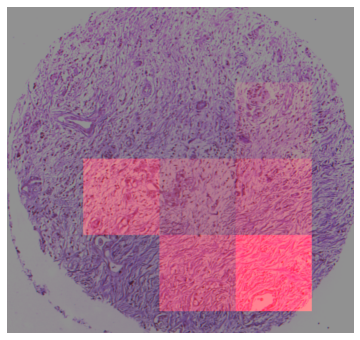

In [16]:
### create attention machine learning model
args = argparse.Namespace()
args.weights = "0814-r2-best.pth"
args.use_cuda = False
args.num_feats = 512
args.num_classes = 2
args.top_k = 4
args.task_name = "default"
resnet18 = models.resnet18(pretrained=False, norm_layer=nn.InstanceNorm2d)
resnet18.fc = nn.Dropout(0.0)
i_classifier = mil.IClassifier(
    resnet18, feature_size=args.num_feats, output_class=args.num_classes
)
b_classifier = mil.BClassifier(input_size=args.num_feats, output_class=args.num_classes)
if args.use_cuda:
    milnet = mil.MILNet(i_classifier, b_classifier).cuda()
    state_dict = torch.load(args.weights)
    device = "cuda:0"
else:
    milnet = mil.MILNet(i_classifier, b_classifier)
    state_dict = torch.load(args.weights, map_location=torch.device("cpu"))
    device = "cpu"
model = milnet
model.load_state_dict(state_dict)
TASK = args.task_name
INPUT_PATCH_DIR = "input_patch_temp/"
OUTPUT_DIR = "output_test_" + TASK
OUTPUT_PATCH_DIR = "output_patch_temp/"
CHANNEL_DIR = "channel_temp/"
top_patch_coords = []
if os.path.exists(CHANNEL_DIR):
    shutil.rmtree(CHANNEL_DIR, onerror=on_rm_error)
os.mkdir(CHANNEL_DIR)
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR, onerror=on_rm_error)
os.mkdir(OUTPUT_DIR)

window_shape = (224, 224, 3)
step_size = 224
optimal_threshs = (0.823, 0.7)

print("forward pass, please wait...")
if os.path.exists(INPUT_PATCH_DIR):
    shutil.rmtree(INPUT_PATCH_DIR, onerror=on_rm_error)
if os.path.exists(OUTPUT_PATCH_DIR):
    try:
        shutil.rmtree(OUTPUT_PATCH_DIR, onerror=on_rm_error)
    except:
        pass
makedirs(INPUT_PATCH_DIR, exist_ok=True)
makedirs(OUTPUT_PATCH_DIR, exist_ok=True)

img = copy.deepcopy(bounded_tma)
pad_h = int(np.ceil(img.shape[0] / window_shape[0]) * window_shape[0]) - img.shape[0]
pad_w = int(np.ceil(img.shape[1] / window_shape[1]) * window_shape[1]) - img.shape[1]
canvas = pad(img, ((0, pad_h), (0, pad_w), (0, 0)), mode="constant", constant_values=1)

windows = view_as_windows(canvas, window_shape, step_size)
with open(OUTPUT_PATCH_DIR + "TileConfiguration.txt", "w") as text_file:
    print("dim = {}".format(2), file=text_file)
    for i in range(0, windows.shape[1]):
        for j in range(0, windows.shape[0]):
            patch = windows[
                j,
                i,
            ]
            patch = np.squeeze(patch)
            if thresSaturation(patch, 10):
                io.imsave(
                    INPUT_PATCH_DIR + "/{}_{}.tiff".format(j, i), img_as_ubyte(patch)
                )
                print(
                    "{}_{}.tiff; ; ({}, {})".format(j, i, i * step_size, j * step_size),
                    file=text_file,
                )
csv_file_path = generate_csv(INPUT_PATCH_DIR, os.getcwd())
dataloader = test_dataset(csv_file_path)
with open(csv_file_path) as f:
    reader = csv.reader(f)
    name_list = list(reader)
    with torch.no_grad():
        for iteration, batch in enumerate(dataloader):
            patches = (
                batch["input"].float().to(device)
            )  # .view(1, 3, window_shape[0], window_shape[1])
            classes, bag_prediction, A = milnet(patches)  # n X L
            bag_prediction_data = torch.sigmoid(bag_prediction).cpu().squeeze().numpy()

            indicator_class = 1  # 0 cp, 1 n, 2 pc
            if bag_prediction_data[1] > optimal_threshs[1]:
                indicator_class = 2
            elif bag_prediction_data[0] > optimal_threshs[0]:
                indicator_class = 0
        i = 0
        A = A.cpu().numpy()
        A_max = np.max(A)
        A_min = np.min(A)
        k = 1 / (A_max - A_min)
        b = -A_min / (A_max - A_min)
        for a in A:
            a_cp = np.clip(a[0] * k + b, 0, 1)
            a_pc = np.clip(a[1] * k + b, 0, 1)
            patch_color = (a_pc, 0, a_cp)
            if indicator_class == 1:
                patch_color = (0, 0, 0)
            elif indicator_class == 0:
                patch_color = (0, 0, a_cp)
            elif indicator_class == 2:
                patch_color = (a_pc, 0, 0)

            patch_result = img_as_ubyte(
                np.tile(np.array(patch_color), (step_size, step_size, 1))
            )
            img_name = str(name_list[i]).split("/")[-1].split("'")[0]
            io.imsave(OUTPUT_PATCH_DIR + img_name, patch_result)
            i = i + 1

        indices = np.argsort(A[:, 1])[::-1]
        indices = indices[: args.top_k]
        top_patch_names = [
            str(name_list[i]).split("/")[-1].split("'")[0] for i in indices
        ]
        for top_patch_name in top_patch_names:
            y_coord = (
                int(top_patch_name.split(".")[0].split("_")[0]) * window_shape[0]
                + window_shape[0] / 2
            )
            x_coord = (
                int(top_patch_name.split(".")[0].split("_")[1]) * window_shape[1]
                + window_shape[1] / 2
            )
            top_patch_coords.append((x_coord, y_coord))
        print(top_patch_coords)

print("stitching, please wait...")
params = {
    "type": "Positions from file",
    "order": "Defined by TileConfiguration",
    "directory": OUTPUT_PATCH_DIR,
    "ayout_file": "TileConfiguration.txt",
    "fusion_method": "Max. Intensity",
    "regression_threshold": "0.30",
    "max/avg_displacement_threshold": "2.50",
    "absolute_displacement_threshold": "3.50",
    "compute_overlap": False,
    "computation_parameters": "Save computation time (but use more RAM)",
    "image_output": "Write to disk",
    "output_directory": CHANNEL_DIR,
}
plugin = "Grid/Collection stitching"
ij.py.run_plugin(plugin, params)

output_name = os.path.join(OUTPUT_DIR, "test.tif")
listOfChannels = [f for f in os.listdir(CHANNEL_DIR)]
c1 = io.imread(os.path.join(CHANNEL_DIR, listOfChannels[0]))
c2 = io.imread(os.path.join(CHANNEL_DIR, listOfChannels[1]))
c3 = io.imread(os.path.join(CHANNEL_DIR, listOfChannels[2]))
c1 = c1[: img.shape[0], : img.shape[1]]
c2 = c2[: img.shape[0], : img.shape[1]]
c3 = c3[: img.shape[0], : img.shape[1]]
img_to_save = np.stack((c1, c2, c3)).transpose(1, 2, 0)
img_to_save = exposure.rescale_intensity(
    img_as_float(img_to_save), in_range=(0.2, 1), out_range=(0, 1)
)
pad_h = img.shape[0] - img_to_save.shape[0]
pad_w = img.shape[1] - img_to_save.shape[1]
img_to_save = pad(img_to_save, ((0, pad_h), (0, pad_w), (0, 0)))
img = img_as_float(img[:, :, :3] * 0.6)
img_to_save = exposure.rescale_intensity(
    img_to_save, in_range=(0.2, 0.8), out_range=(0, 0.9)
)
img_to_save = np.clip((img_to_save + img), 0, 1)
print("saved at: " + OUTPUT_DIR)
io.imsave(output_name, img_as_ubyte(img_to_save))
plt.figure(figsize=(8, 6))
imgplot = plt.imshow(img_as_ubyte(img_to_save))
plt.axis("off")
plt.show()

ROIs with top 4 attention scores are selected. The image coordinates of the ROIs are mapped to the xy stage positions. The transformation between image coordinates and stage positions need to be determined by landmarks calibration, which only has to be done once for the same objective.

In [17]:
pixel_size = 1.282
x_pos = core.get_x_position()
y_pos = core.get_y_position()
off_set_x = box[0] * pixel_size + 84
off_set_y = box[1] * pixel_size - 52
pos_list = []
for top_patch_coord in top_patch_coords:
    pos_list.append(
        (
            x_pos + (448 - top_patch_coord[0]) * pixel_size,
            y_pos + (448 - top_patch_coord[1]) * pixel_size,
        )
    )

In [18]:
pos_list

[(10962.488, -4629.912),
 (11249.655999999999, -4629.912),
 (11536.824, -4342.744),
 (10962.488, -4342.744)]

### Perform SHG imaging at the selected regions
Switch to the 20x objective, and switch the modality to SHG laser scanning microscopy.

In [20]:
switch_objective("20x")
switch_shg(hard_set=True)

Swtich to objective: 20x
Switched to SHG, current obejective: 20x


Focus offset between brightfield and SHG imaging.

In [31]:
z_pos = core.get_position()
z_shg_center = z_pos + 136
core.set_position(z_shg_center)

### Iterate the ROIs
Z-stack is collected at each ROI via multi_d_acquisition_events.

In [34]:
for i, pos in enumerate(pos_list):
    core.set_xy_position(pos[0], pos[1])
    with Acquisition(directory="test", name="exp_2-1_1024_pos_" + str(i)) as acq:
        events = multi_d_acquisition_events(
            z_start=z_shg_center - 20, z_end=z_shg_center + 20, z_step=5
        )
        acq.acquire(events)
bridge.close()

Plot the projected z-stack images at the selected locations.

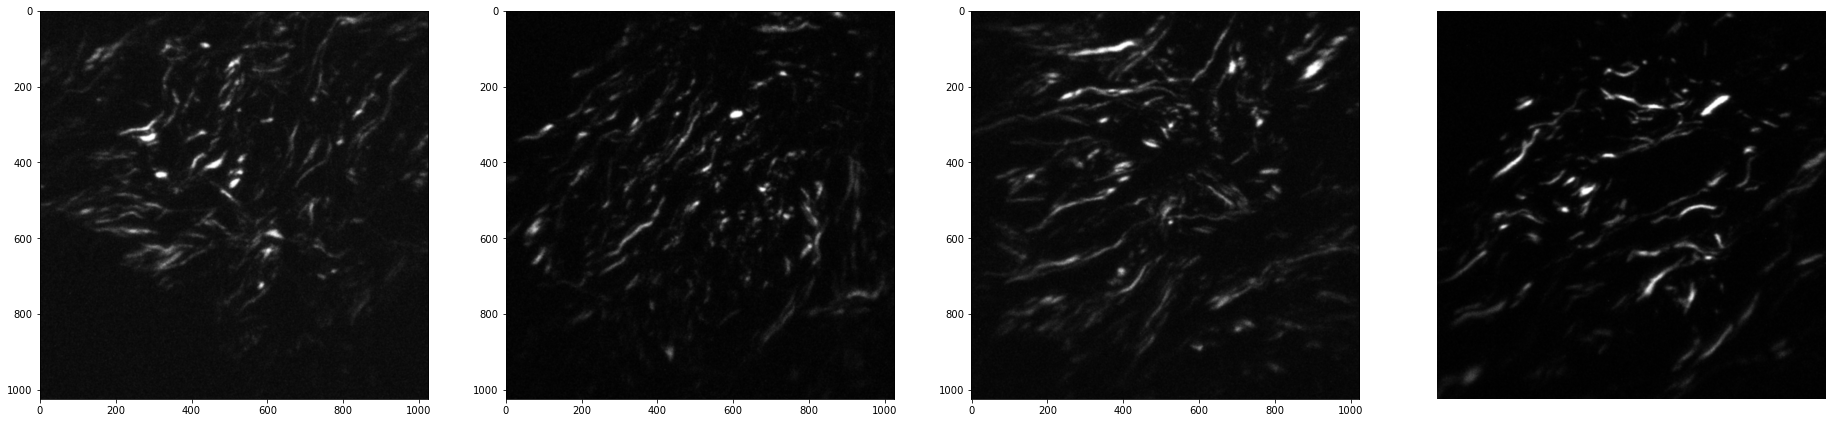

In [35]:
img0 = io.imread("brightfield\\exp_02\\pos_0.tif")
img1 = io.imread("brightfield\\exp_02\\pos_1.tif")
img2 = io.imread("brightfield\\exp_02\\pos_2.tif")
img3 = io.imread("brightfield\\exp_02\\pos_3.tif")

f, axarr = plt.subplots(1, 4, figsize=(32, 96))
axarr[0].imshow(img0, cmap="gray", interpolation="bicubic")
axarr[1].imshow(img1, cmap="gray", interpolation="bicubic")
axarr[2].imshow(img2, cmap="gray", interpolation="bicubic")
axarr[3].imshow(img3, cmap="gray", interpolation="bicubic")
plt.axis("off")
plt.show()

In [27]:
io.imsave("brightfield\\exp_02\\raw.tiff", pixels)

In [28]:
io.imsave("brightfield\\exp_02\\corrected.tiff", img_as_ubyte(output))

In [29]:
io.imsave("brightfield\\exp_02\\bounded.tiff", img_as_ubyte(bounded_tma))